# Train and Evaluate Deep Learning Models for MIMIC Dataset

In [1]:
from importlib import resources as impresources
import os

from recurrent_health_events_prediction.utils.general_utils import import_yaml_config
from recurrent_health_events_prediction import configs

data_config = import_yaml_config(
    impresources.files(configs) / "data_config.yaml"
)

training_data_config = data_config['training_data']["mimic"]
data_directory = training_data_config['data_directory']

OVERWRITE_PREPROCESSED = True

In [2]:
print("Train and test data directory:", data_directory)

Train and test data directory: /workspaces/msc-thesis-recurrent-health-modeling/data/mimic-iii-preprocessed/copd_hf_renal_diabetes/multiple_hosp_patients/train_test


In [3]:
model_name = "attention_pooling"
model_config_path =f"/workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/{model_name}/{model_name}_config.yaml"
 
model_config = import_yaml_config(model_config_path)
for key, value in model_config.items():
    print(f"{key}: {value}")

model_params_dict = model_config['model_params']
assert model_params_dict['input_size_curr'] == len(model_config['current_feat_cols'])
assert model_params_dict['input_size_seq'] == len(model_config['longitudinal_feat_cols'])

model_name: Attention Pooling
batch_size: 64
num_epochs: 30
learning_rate: 0.001
model_class: AttentionPoolingNet
longitudinal_feat_cols: ['LOG_HOSPITALIZATION_DAYS', 'LOG_DAYS_IN_ICU', 'CHARLSON_INDEX', 'LOG_NUM_DRUGS', 'DISCHARGE_LOCATION_POST_ACUTE_CARE', 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION']
current_feat_cols: ['LOG_DAYS_IN_ICU', 'CHARLSON_INDEX', 'LOG_NUM_DRUGS', 'NUM_PROCEDURES', 'DISCHARGE_LOCATION_POST_ACUTE_CARE', 'LOG_PARTICIPATION_DAYS', 'AGE', 'GENDER_M', 'ADMISSION_TYPE_ELECTIVE', 'ETHNICITY_WHITE']
max_sequence_length: 4
no_elective: True
reverse_chronological_order: False
model_params: {'input_size_curr': 10, 'hidden_size_head': 16, 'input_size_seq': 6, 'hidden_size_seq': 4, 'dropout': 0.1}


In [4]:
save_results_dir = os.path.dirname(model_config_path) + "/multiple_hosp_patients"
print("Model results will be saved to:", save_results_dir)

Model results will be saved to: /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/attention_pooling/multiple_hosp_patients


In [5]:
# Prepare datasets (load existing or create + save new)
from recurrent_health_events_prediction.training.train_deep_learning_models import prepare_train_test_datasets


train_dataset, test_dataset, last_events_test_dataset, train_df_path, test_df_path = prepare_train_test_datasets(
    data_directory=data_directory,
    training_data_config=training_data_config,
    model_config=model_config,
    save_output_dir_path=save_results_dir,
    save_scaler_dir_path=None,
    overwrite_preprocessed=OVERWRITE_PREPROCESSED,
)

Preparing train and test datasets...
Creating new PyTorch datasets...
Test dataset (all events) size: 1085
Test dataset (last events only) size: 353
Saved PyTorch datasets to /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/attention_pooling/multiple_hosp_patients


## Inspect Train Data

In [6]:
import pandas as pd

train_df = pd.read_csv(train_df_path)

train_df[model_config['current_feat_cols']].describe()

,LOG_DAYS_IN_ICU,CHARLSON_INDEX,LOG_NUM_DRUGS,NUM_PROCEDURES,LOG_PARTICIPATION_DAYS,AGE
count,4.792000e+03,4.792000e+03,4.792000e+03,4.792000e+03,4792.000000,4.792000e+03
mean,-1.542079e-16,-1.542079e-16,-2.965537e-17,8.896612e-17,0.000000,3.410368e-17
std,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104,1.000104e+00
min,-1.776959e+00,-1.986906e+00,-2.987183e+00,-1.049072e+00,-1.941365,-2.623989e+00
25%,-7.121231e-01,-7.857893e-01,-6.958393e-02,-7.709598e-01,-0.941402,-6.492785e-01
50%,-1.927152e-01,1.495548e-02,2.501776e-01,-2.147359e-01,0.148044,9.123818e-02
75%,4.891051e-01,8.157002e-01,5.276853e-01,3.414881e-01,0.903392,7.700451e-01
max,4.729545e+00,4.018679e+00,1.594263e+00,5.347504e+00,1.626968,1.757401e+00


In [7]:
train_df[model_config["longitudinal_feat_cols"]].describe()

,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,CHARLSON_INDEX,LOG_NUM_DRUGS,LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION
count,4.792000e+03,4.792000e+03,4.792000e+03,4.792000e+03,4.792000e+03
mean,-2.031393e-16,-1.542079e-16,-1.542079e-16,-2.965537e-17,-3.558645e-17
std,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00
min,-2.432086e+00,-1.776959e+00,-1.986906e+00,-2.987183e+00,-2.341308e+00
25%,-6.674366e-01,-7.121231e-01,-7.857893e-01,-6.958393e-02,-7.434079e-01
50%,-8.346424e-02,-1.927152e-01,1.495548e-02,2.501776e-01,5.707672e-02
75%,6.023691e-01,4.891051e-01,8.157002e-01,5.276853e-01,8.074353e-01
max,4.061836e+00,4.729545e+00,4.018679e+00,1.594263e+00,2.081791e+00


In [8]:
test_df = pd.read_csv(test_df_path)

test_df[model_config['current_feat_cols']].describe()

,LOG_DAYS_IN_ICU,CHARLSON_INDEX,LOG_NUM_DRUGS,NUM_PROCEDURES,LOG_PARTICIPATION_DAYS,AGE
count,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000
mean,0.039402,0.002865,0.004981,-0.011491,-0.049707,0.102313
std,1.008152,0.995275,1.004078,0.996198,0.993121,0.951231
min,-1.776959,-1.986906,-2.987183,-1.049072,-1.941365,-2.623989
25%,-0.700478,-0.785789,-0.069584,-0.770960,-0.999885,-0.525859
50%,-0.175213,0.014955,0.250178,-0.214736,0.056942,0.214658
75%,0.573555,0.415328,0.527685,0.341488,0.854676,0.893465
max,3.629250,4.018679,1.438056,5.347504,1.559036,1.695691


In [9]:
test_df = pd.read_csv(test_df_path)
test_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,HAS_DIABETES,HAS_COPD,HAS_CONGESTIVE_HF,...,ADMISSION_TYPE_URGENT,INSURANCE_GOVERNMENT,INSURANCE_MEDICAID,INSURANCE_MEDICARE,INSURANCE_PRIVATE,ETHNICITY_BLACK,ETHNICITY_HISPANIC,ETHNICITY_WHITE,DISCHARGE_LOCATION_HOME,DISCHARGE_LOCATION_POST_ACUTE_CARE
0,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,8.281250,-1.074221,"['other', 'chronic_pulmonary_disease']",False,True,False,...,False,False,False,True,False,False,False,True,True,False
1,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,12.736806,-1.074221,"['other', 'chronic_pulmonary_disease']",False,True,False,...,False,False,False,True,False,False,False,True,False,True
2,107,191941,2115-02-20 17:41:00,2115-02-21 16:30:00,0.950694,-1.074221,"['other', 'renal_disease']",False,False,False,...,False,False,False,False,True,False,True,False,True,False
3,107,182383,2121-11-30 19:24:00,2121-12-05 14:18:00,4.787500,0.418506,"['other', 'congestive_heart_failure', 'myocard...",False,False,True,...,False,False,False,True,False,False,True,False,True,False
4,188,160697,2157-01-11 16:56:00,2157-01-19 14:58:00,7.918056,0.418506,"['mild_liver_disease', 'malignant_cancer', 'se...",False,False,False,...,False,False,False,False,True,False,False,True,True,False


In [10]:
# select patients (SUBJECT_ID) with more than 2 past hospitalizations
counts = test_df['SUBJECT_ID'].value_counts()
subject_ids_multi = counts[counts > 2].index

# use .isin to create a row-aligned boolean mask
test_mult_past_df = test_df[test_df['SUBJECT_ID'].isin(subject_ids_multi)]
test_mult_past_df.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,HAS_DIABETES,HAS_COPD,HAS_CONGESTIVE_HF,...,ADMISSION_TYPE_URGENT,INSURANCE_GOVERNMENT,INSURANCE_MEDICAID,INSURANCE_MEDICARE,INSURANCE_PRIVATE,ETHNICITY_BLACK,ETHNICITY_HISPANIC,ETHNICITY_WHITE,DISCHARGE_LOCATION_HOME,DISCHARGE_LOCATION_POST_ACUTE_CARE
4,188,160697,2157-01-11 16:56:00,2157-01-19 14:58:00,7.918056,0.418506,"['mild_liver_disease', 'malignant_cancer', 'se...",False,False,False,...,False,False,False,False,True,False,False,True,True,False
5,188,191517,2157-03-07 11:08:00,2157-03-10 13:50:00,3.112500,-0.327858,"['other', 'mild_liver_disease', 'diabetes_with...",True,False,False,...,False,False,False,False,True,False,False,True,True,False
6,188,150463,2157-11-17 12:11:00,2157-11-20 13:05:00,3.037500,-1.074221,"['other', 'mild_liver_disease']",False,False,False,...,False,False,False,False,True,False,False,True,True,False
7,188,192557,2160-11-25 21:55:00,2160-11-28 12:42:00,2.615972,0.418506,"['other', 'mild_liver_disease', 'diabetes_with...",True,False,False,...,False,False,False,False,True,False,False,True,True,False
8,188,123860,2160-12-31 12:34:00,2161-01-08 19:50:00,8.302778,1.164869,"['other', 'mild_liver_disease', 'diabetes_with...",True,False,False,...,False,False,False,False,True,False,False,True,True,False
9,188,164735,2161-07-01 19:44:00,2161-07-10 20:00:00,9.011111,0.418506,"['other', 'mild_liver_disease', 'diabetes_with...",True,False,False,...,False,False,False,False,True,False,False,True,True,False
12,773,171563,2103-07-19 21:18:00,2103-08-12 08:08:00,23.451389,-1.820585,['other'],False,False,False,...,False,False,False,False,True,False,False,True,False,True
13,773,183287,2108-12-25 23:57:00,2108-12-29 15:05:00,3.630556,1.164869,"['other', 'malignant_cancer', 'mild_liver_dise...",False,False,True,...,False,False,False,False,True,False,False,True,True,False
14,773,160425,2109-01-23 21:51:00,2109-01-28 17:00:00,4.797917,1.911233,"['peptic_ulcer_disease', 'other', 'malignant_c...",False,False,True,...,False,False,False,False,True,False,False,True,True,False
19,878,105643,2131-05-16 18:32:00,2131-05-30 14:30:00,13.831944,-0.327858,"['other', 'congestive_heart_failure', 'chronic...",False,True,True,...,False,False,False,True,False,True,False,False,True,False


### Create PyTorch Datasets

In [11]:
print("Output directory for model results:", save_results_dir)

Output directory for model results: /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/attention_pooling/multiple_hosp_patients


## Train the Model

In [12]:
from recurrent_health_events_prediction.training.train_deep_learning_models import train
from recurrent_health_events_prediction.model.RecurrentHealthEventsDL import GRUNet

model, loss_epochs = train(
    train_dataset=train_dataset,
    model_config=model_config,
)


Using model class: AttentionPoolingNet

Model initialized and ready for training.
Model parameters:
  input_size_curr: 10
  hidden_size_head: 16
  input_size_seq: 6
  hidden_size_seq: 4
  dropout: 0.1

Starting training...
Number of training samples: 4434
Batch size: 64
Learning rate: 0.001
Optimizer: Adam
Loss function: BCEWithLogitsLoss

Epoch 1/30, Loss: 0.6111659850393023
Epoch 2/30, Loss: 0.5772927331072943
Epoch 3/30, Loss: 0.5681049644947052
Epoch 4/30, Loss: 0.5651509523391723
Epoch 5/30, Loss: 0.5620740813868387
Epoch 6/30, Loss: 0.5597144024712699
Epoch 7/30, Loss: 0.5601154897894178
Epoch 8/30, Loss: 0.5555257414068494
Epoch 9/30, Loss: 0.5541444467646736
Epoch 10/30, Loss: 0.5551484171833311
Epoch 11/30, Loss: 0.5502634478466851
Epoch 12/30, Loss: 0.5508540953908648
Epoch 13/30, Loss: 0.5491658513035093
Epoch 14/30, Loss: 0.5489523781197412
Epoch 15/30, Loss: 0.54972037928445
Epoch 16/30, Loss: 0.5479484396321433
Epoch 17/30, Loss: 0.5486318409442902
Epoch 18/30, Loss: 0.5

In [13]:
import plotly.graph_objects as go

batch_size = model_config['batch_size']
num_samples = len(train_dataset)

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=loss_epochs,
    x=list(range(1, len(loss_epochs) + 1)),
    mode='lines+markers',
    name='Training Loss'
))
fig.update_layout(
    title=f"Training Loss per Epoch (Batch size: {batch_size}, Train samples: {num_samples})",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    template="plotly_white"
)
fig.write_html(os.path.join(save_results_dir, "training_loss.html"))
fig.show()

In [14]:
import torch

model_save_path = os.path.join(save_results_dir, f"{model_name}.pt")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/attention_pooling/multiple_hosp_patients/attention_pooling.pt


## Load Model

In [15]:
from recurrent_health_events_prediction.model.RecurrentHealthEventsDL import GRUNet, AttentionPoolingNet

model_save_path = os.path.join(save_results_dir, f"{model_name}.pt")
model = AttentionPoolingNet(**model_params_dict)
model.load_state_dict(torch.load(model_save_path))
model.eval()

AttentionPoolingNet(
  (proj): Linear(in_features=6, out_features=4, bias=False)
  (classifier_head): Sequential(
    (fc1): Linear(in_features=14, out_features=16, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)

## Evaluate the Model

### Train Set

In [16]:
from recurrent_health_events_prediction.training.train_deep_learning_models import evaluate

test_metrics, all_pred_labels, all_pred_probs, all_labels, all_attention_scores = evaluate(
    model=model,
    test_dataset=train_dataset,
    batch_size=32
)
for key, value in test_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

Starting evaluation...
Number of test samples: 4434
Batch size: 32

f1_score: 0.4781
auroc: 0.6680
best_threshold: 0.2560
confusion_matrix: [[1878 1388]
 [ 365  803]]
recall: 0.6875
accuracy: 0.6046
precision: 0.3665


### Test Set Evaluation

#### All Events

In [17]:
from recurrent_health_events_prediction.training.train_deep_learning_models import evaluate

test_metrics, all_pred_labels, all_pred_probs, all_labels, all_attention_scores = evaluate(
    model=model,
    test_dataset=test_dataset,
    batch_size=32
)
for key, value in test_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

Starting evaluation...
Number of test samples: 1085
Batch size: 32

f1_score: 0.4194
auroc: 0.5869
best_threshold: 0.1789
confusion_matrix: [[207 599]
 [ 46 233]]
recall: 0.8351
accuracy: 0.4055
precision: 0.2800


#### Last Events

In [18]:
test_metrics_last_events, all_pred_labels, all_pred_probs, all_labels, all_attention_scores = evaluate(
    model=model,
    test_dataset=last_events_test_dataset,
    batch_size=32
)
for key, value in test_metrics_last_events.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

Starting evaluation...
Number of test samples: 353
Batch size: 32

f1_score: 0.4286
auroc: 0.6010
best_threshold: 0.1830
confusion_matrix: [[ 56 206]
 [ 10  81]]
recall: 0.8901
accuracy: 0.3881
precision: 0.2822


In [19]:
test_pred_df = pd.DataFrame({
    "true_label": all_labels,
    "pred_label": all_pred_labels,
    "pred_prob": all_pred_probs
})

test_pred_df.to_csv(os.path.join(save_results_dir, "test_predictions.csv"), index=False)

In [20]:
from recurrent_health_events_prediction.training.utils import plot_pred_proba_distribution

plot_pred_proba_distribution(test_pred_df["true_label"], test_pred_df["pred_prob"], show_plot=False)

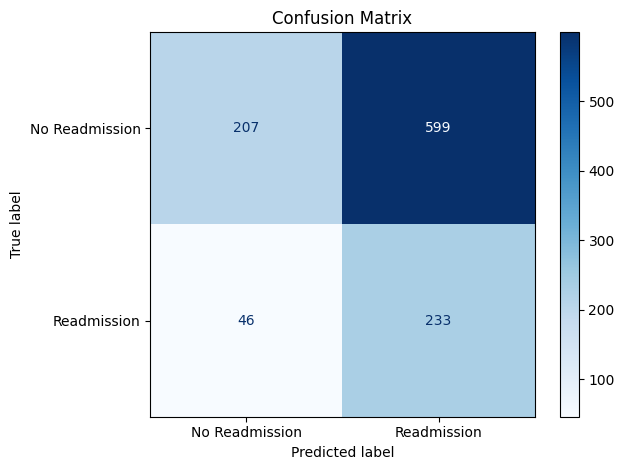

In [21]:
from recurrent_health_events_prediction.training.utils import plot_confusion_matrix

class_names=training_data_config["class_names"]
plot_confusion_matrix(test_metrics["confusion_matrix"], class_names)

### Inspect Visit-Level Attention Scores

In [22]:
all_attention_scores[:5]

array([[1.        , 0.        , 0.        , 0.        ],
       [0.2665479 , 0.2763644 , 0.27937517, 0.17771254],
       [1.        , 0.        , 0.        , 0.        ],
       [0.41978684, 0.5802131 , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [23]:
idx = 1  # index of the sample to inspect
selected_sample = last_events_test_dataset.samples[idx]
subject_id = selected_sample['subject_id']
print("Subject ID:", subject_id)
print("True label:", selected_sample['y'])
print("Sample: ", selected_sample)

Subject ID: 188
True label: 0.0
Sample:  {'x_past': array([[-1.0555028 , -0.7492469 , -0.7857893 ,  0.2227712 ,  0.        ,
         0.4901109 ],
       [-1.0806242 , -0.7563539 , -1.1861616 , -0.14946435,  0.        ,
         1.3516698 ],
       [-1.2311238 , -0.90875703,  0.01495548, -0.14946435,  0.        ,
        -0.6844576 ],
       [ 0.05863306,  0.09426811,  0.81570023,  0.42204636,  0.        ,
         0.2745275 ]], dtype=float32), 'x_current': array([ 0.39608583,  0.01495548,  0.54742897,  1.7320479 ,  0.        ,
        1.1941806 , -0.27902013,  1.        ,  0.        ,  1.        ],
      dtype=float32), 'mask_past': array([ True,  True,  True,  True]), 'y': 0.0, 'subject_id': 188, 'seq_len': 4, 't_index': 6}


In [24]:
long_feat_cols = model_config['longitudinal_feat_cols']
long_feat_cols

['LOG_HOSPITALIZATION_DAYS',
 'LOG_DAYS_IN_ICU',
 'CHARLSON_INDEX',
 'LOG_NUM_DRUGS',
 'DISCHARGE_LOCATION_POST_ACUTE_CARE',
 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION']

In [25]:
test_df.loc[test_df['SUBJECT_ID'] == subject_id, ["HADM_ID", "ADMITTIME"] + long_feat_cols].tail(5)

,HADM_ID,ADMITTIME,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,CHARLSON_INDEX,LOG_NUM_DRUGS,DISCHARGE_LOCATION_POST_ACUTE_CARE,LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION
5,191517,2157-03-07 11:08:00,-1.055503,-0.749247,-0.785789,0.222771,False,0.490111
6,150463,2157-11-17 12:11:00,-1.080624,-0.756354,-1.186162,-0.149464,False,1.351670
7,192557,2160-11-25 21:55:00,-1.231124,-0.908757,0.014955,-0.149464,False,-0.684458
8,123860,2160-12-31 12:34:00,0.058633,0.094268,0.815700,0.422046,False,0.274527
9,164735,2161-07-01 19:44:00,0.158792,0.396086,0.014955,0.547429,False,0.028351


In [26]:
all_attention_scores[idx]

array([0.2665479 , 0.2763644 , 0.27937517, 0.17771254], dtype=float32)

In [27]:
model

AttentionPoolingNet(
  (proj): Linear(in_features=6, out_features=4, bias=False)
  (classifier_head): Sequential(
    (fc1): Linear(in_features=14, out_features=16, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)